In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import nilearn
from nilearn import surface as nisurf

import mni_utils as uti
from mni_plots import plot_corr, plot_sc_fit, plot_stages_diff, plot_parcellated_metric, plot_hip_amy

### Paths and names

In [3]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
res_dir = "Results_SC_gamma"
res_tau_dir = "Results_gamma"
res_path = data_path.joinpath(res_dir)
res_tau_path = data_path.joinpath(res_tau_dir)
corr_type = "pearson"

## 1) Load SC parameters, timescales and parcellation

Destrieux Parcellation:

In [4]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "aparc.a2009s"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
parc_labels = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)

Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.aparc.a2009s.annot


MNIA - Destrieux mapping:

In [5]:
df_mnia_dest = pd.read_excel(
    data_path.joinpath("mnia_Destrieux_labels.xlsx"), index_col=0
)
df_mnia_dest["Destrieux atlas name"] = df_mnia_dest["Destrieux atlas name"].str.strip(
    "'"
)
df_mnia_dest.rename(
    columns={
        "Destrieux atlas name": "Destrieux",
        "MNIA equivalent": "MNIA",
    },
    inplace=True,
)
df_mnia_dest.drop(columns="Expanded name", inplace=True)

Hippocampus and Amygdala surface:

In [6]:
surface_hip_amy = nisurf.load_surf_mesh(data_path.joinpath("surfaces/Hip_Amy.surf.gii"))
surface_hip_amy = uti.project_hemis_surf(surface_hip_amy, hemis="left")

Harvard-Oxford dataset for subcortical structures:

In [7]:
HO_atlas = nilearn.datasets.fetch_atlas_harvard_oxford(
    "sub-maxprob-thr50-1mm", symmetric_split=False
)

SC results and parameters:

In [8]:
# Dataframe with data on all channles pairs
df_sc_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the total binned data
df_sc_bins_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_bins.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters of df_sc_bins_stages
df_sc_params_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}

# Dataframe with the fit parameters on each MNI region
df_sc_params_mni_stages = {
    stage: pd.read_csv(res_path.joinpath(f"SC_{stage}_fit_mni_regs.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Fitted on binned distance:
df_sc_params_mni_stages_bins = {
    stage: pd.read_csv(
        res_path.joinpath(f"SC_{stage}_fit_mni_regs_bins.csv"), index_col=0
    )
    for stage in ["W", "N3", "R"]
}

Timescales:

In [9]:
# Dataframe with timescales for all electrodes
df_tau = pd.read_csv(res_tau_path.joinpath("all_tau.csv"), index_col=0)

## 2) Plot SC parameters globally and for each region

{'W': array([6.75415482, 0.03953002, 0.00967877]), 'N3': array([6.39203251, 0.06212093, 0.01303064]), 'R': array([5.59125003, 0.03905028, 0.01042404])}


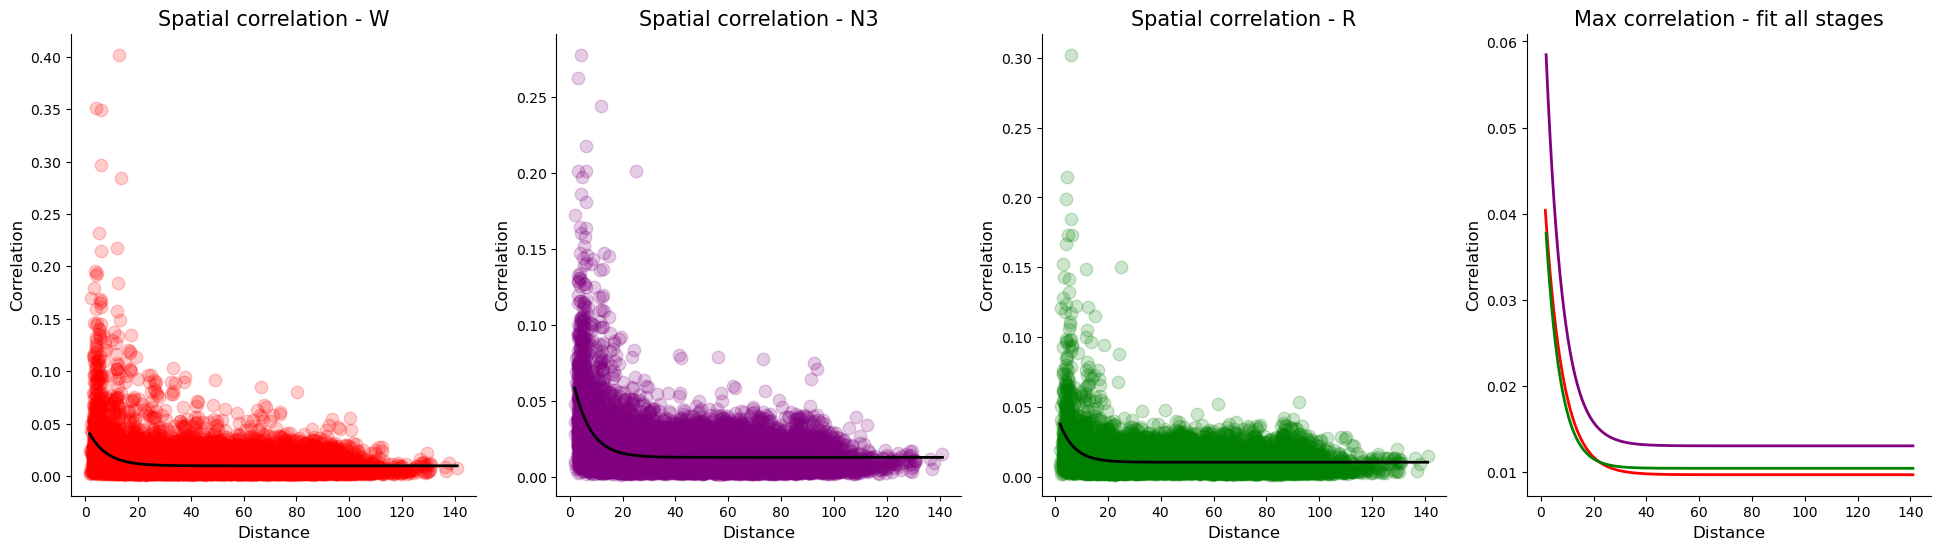

In [7]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
params_stages = {
    stage: par.to_numpy().squeeze() for stage, par in df_sc_params_stages.items()
}
print(params_stages)
fig, axs = plot_sc_fit(df_sc_stages, params_stages, colors_stage)
plt.show()

Plot of regions, "b" parameter:

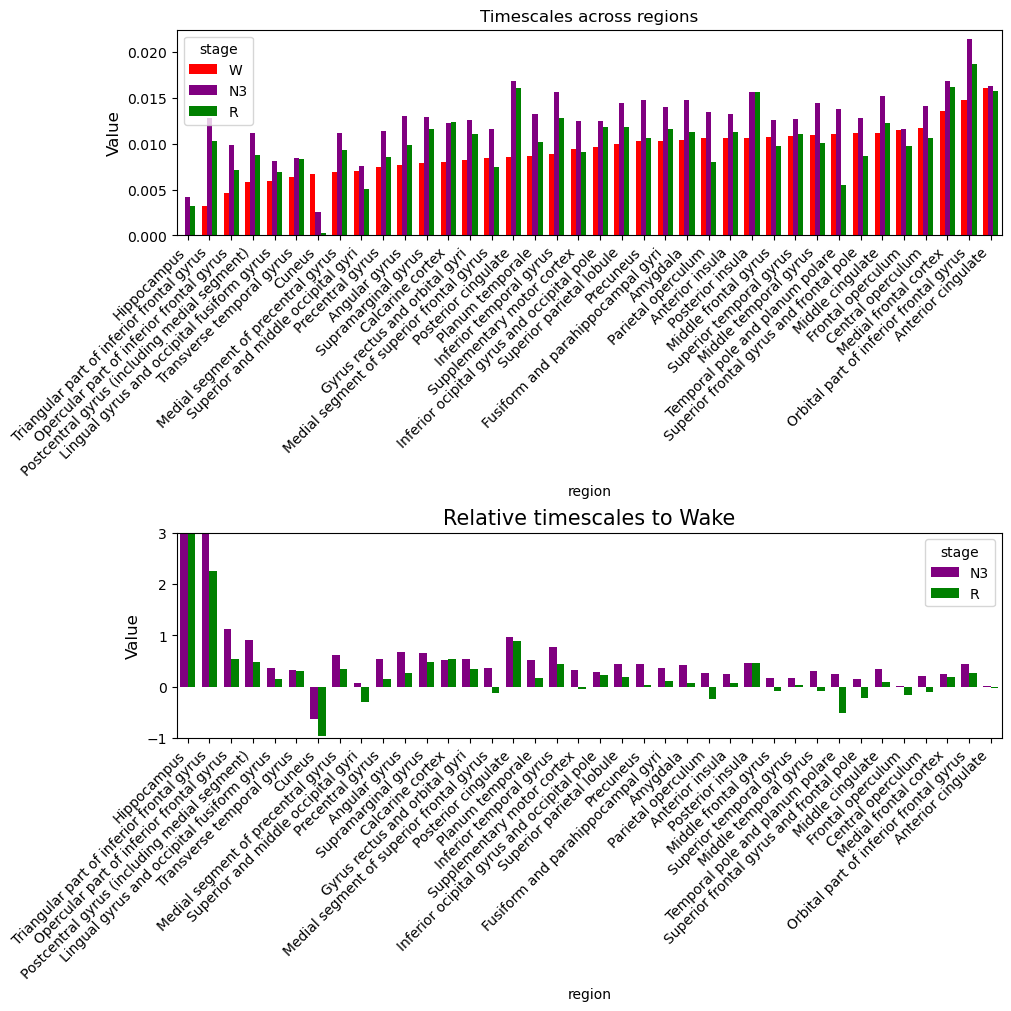

In [13]:
for stage, df in df_sc_params_mni_stages.items():
    if "stage" not in df.columns:
        df.insert(0, "stage", stage)

df_params = pd.concat(df_sc_params_mni_stages.values())
df_params.reset_index(names="region", inplace=True)

fig, axs = plot_stages_diff(df_params, "b")
axs[1].set_ylim(-1, 3)
plt.show()

Plot on Brain map:

In [15]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot parameters for each stage
for stage in ["W", "N3", "R"]:
    print(stage)

    # Select dataframe for the stage for MNI regions
    df_stage_mni = df_sc_params_mni_stages[stage].copy()

    for param in ["k", "a", "b"]:
        print(param)

        # Convert to Destrieux regions
        df_stage_dest = df_mnia_dest.copy()
        df_stage_dest.dropna(inplace=True)
        df_stage_dest[param] = df_stage_mni.loc[
            df_stage_dest["MNIA"].to_list(), param
        ].to_list()
        df_stage_dest = df_stage_dest[["Destrieux", param]].groupby("Destrieux").mean()

        # Create parcellation on cortex
        N_vert = max([max(label.vertices) for label in parc_labels])
        dest_plot_parc = np.zeros((N_vert + 1), dtype=int)
        parc_names = [label.name[:-3] for label in parc_labels]

        for i, (name, label) in enumerate(zip(parc_names, parc_labels)):
            if name in df_stage_dest.index:
                dest_plot_parc[label.vertices] = i + 1

        # Select data for plot and limits
        data_plot = df_stage_dest.loc[parc_names[:-1]].to_numpy().squeeze()
        lims_plot = np.quantile(df_stage_mni[param].to_numpy(), [0.05, 0.95])

        # Plot on cortex
        fig, ax = plot_parcellated_metric(
            data_plot,
            dest_plot_parc,
            subjects_dir,
            log_scale=False,
            minmax=lims_plot,
            title=title_dict[stage],
            cmap="inferno",
            label=param + " parameter",
            cbar_format="2f",
            cbar_ticks=np.round(np.linspace(lims_plot[0], lims_plot[1], 5), 2),
        )
        fig.savefig(res_path.joinpath(f"{param}_mni_parc_{stage}_ctx.png"), dpi=300)
        plt.close(fig)

        # Plot on hippocampus and amygdala
        surface_nodes_labels = uti.get_hip_amy_vtx(HO_atlas, surface_hip_amy)
        val_amy = df_stage_mni.loc["Amygdala", param]
        val_hip = df_stage_mni.loc["Hippocampus", param]
        fig = plot_hip_amy(
            surface_hip_amy, val_hip, val_amy, surface_nodes_labels, lims_plot
        )
        fig.write_image(res_path.joinpath(f"{param}_mni_parc_{stage}_hipamy.png"))

W
k
Using pyvistaqt 3d backend.

a
b
N3
k
a
b
R
k
a
b


## 3) Plot relationship between timescales and SC parameters

In [11]:
map_coords = pd.read_csv(data_path.joinpath("mnia_centroids_coords.csv"), index_col=0)

With the fit on all electrodes pairs:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


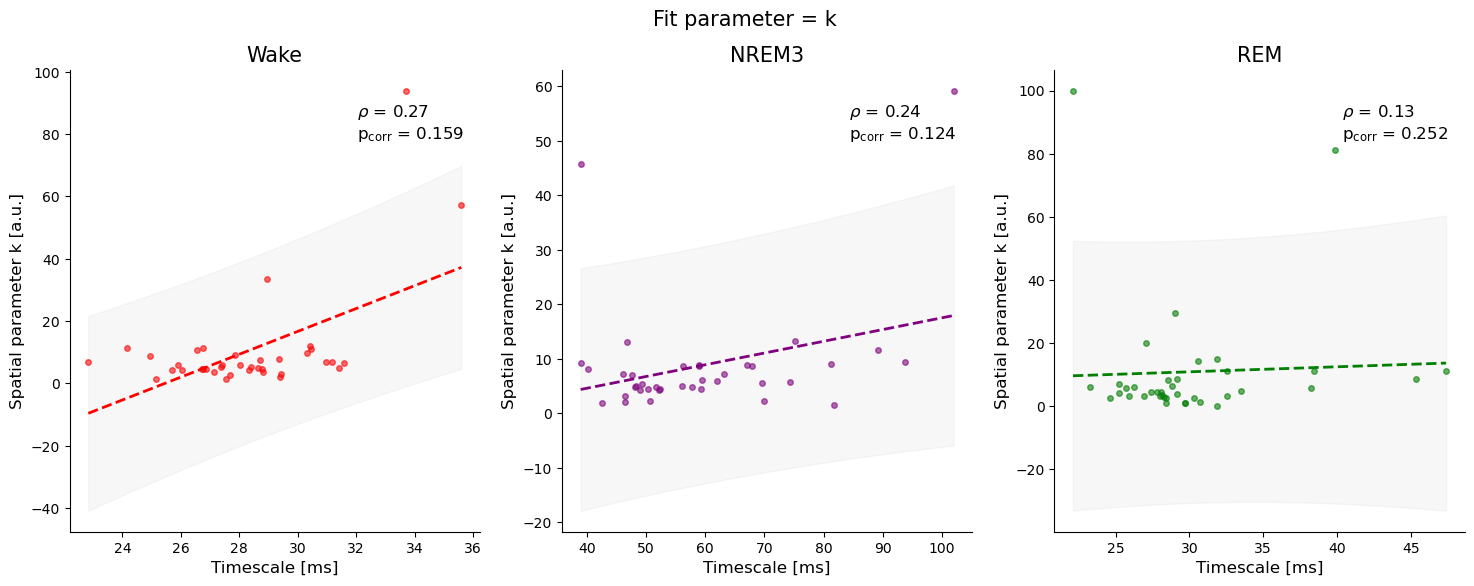

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


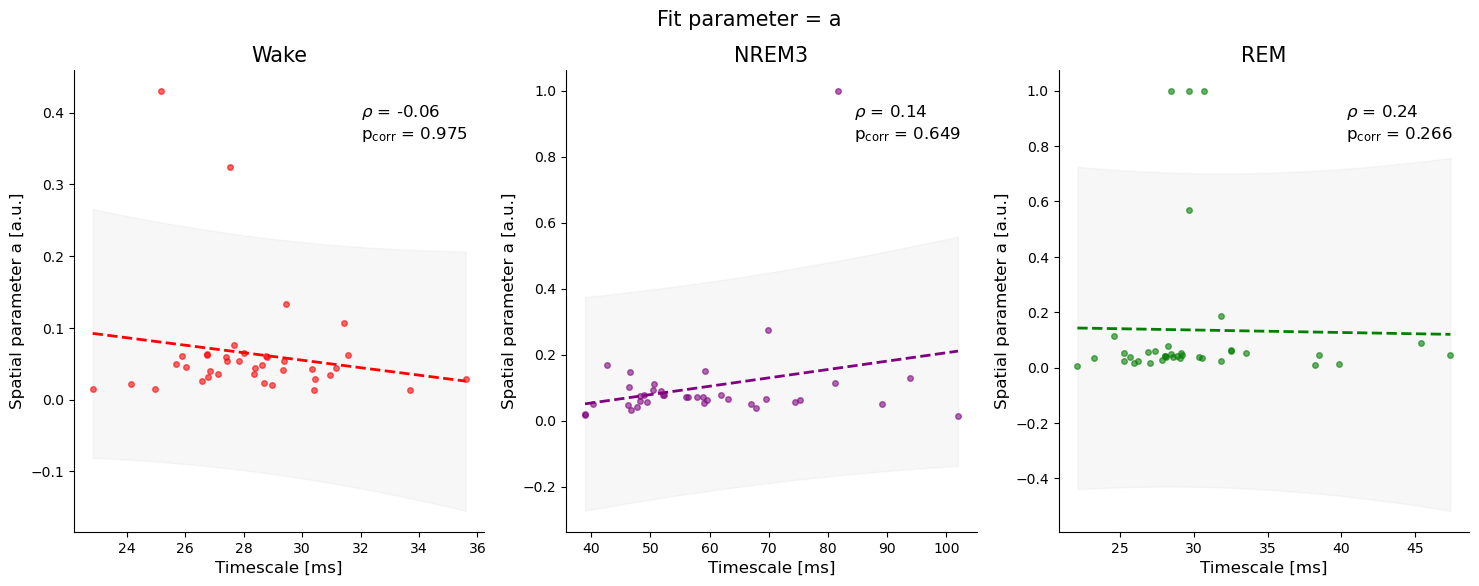

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


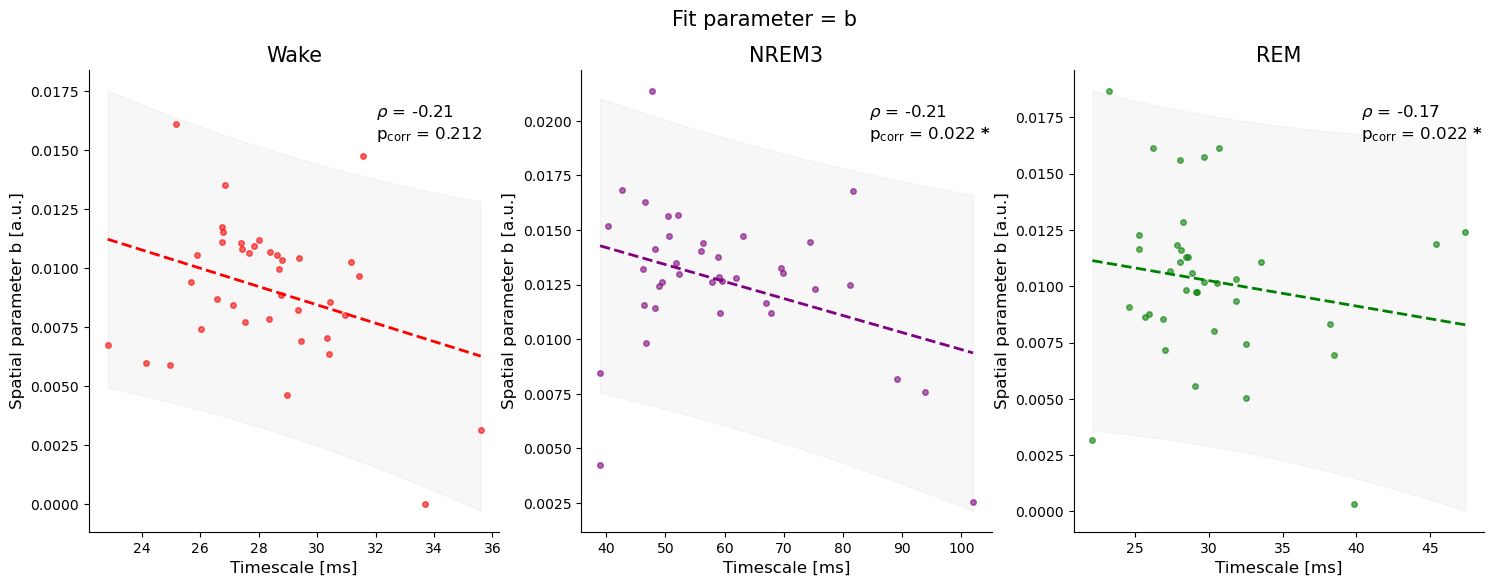

In [15]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage

    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )


    plt.show()

With the fit on bins:

Stage: W, Param: k
Generating 1000 permutations...
Stage: N3, Param: k
Generating 1000 permutations...
Stage: R, Param: k
Generating 1000 permutations...


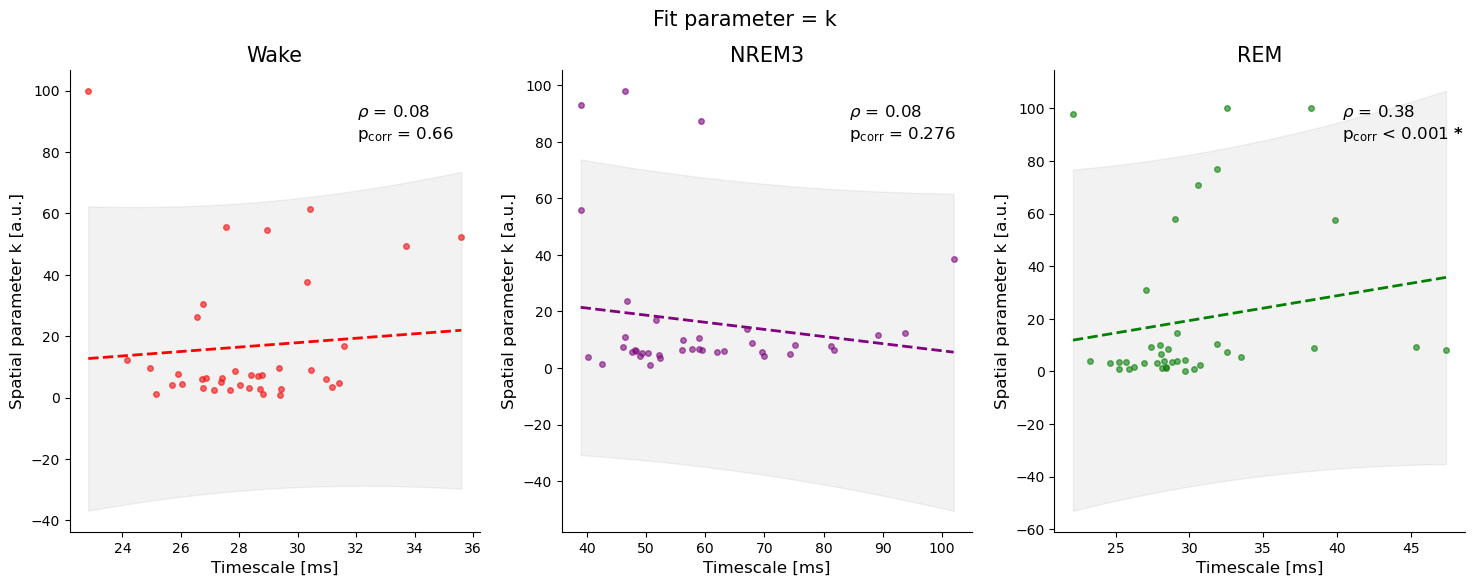

Stage: W, Param: a
Generating 1000 permutations...
Stage: N3, Param: a
Generating 1000 permutations...
Stage: R, Param: a
Generating 1000 permutations...


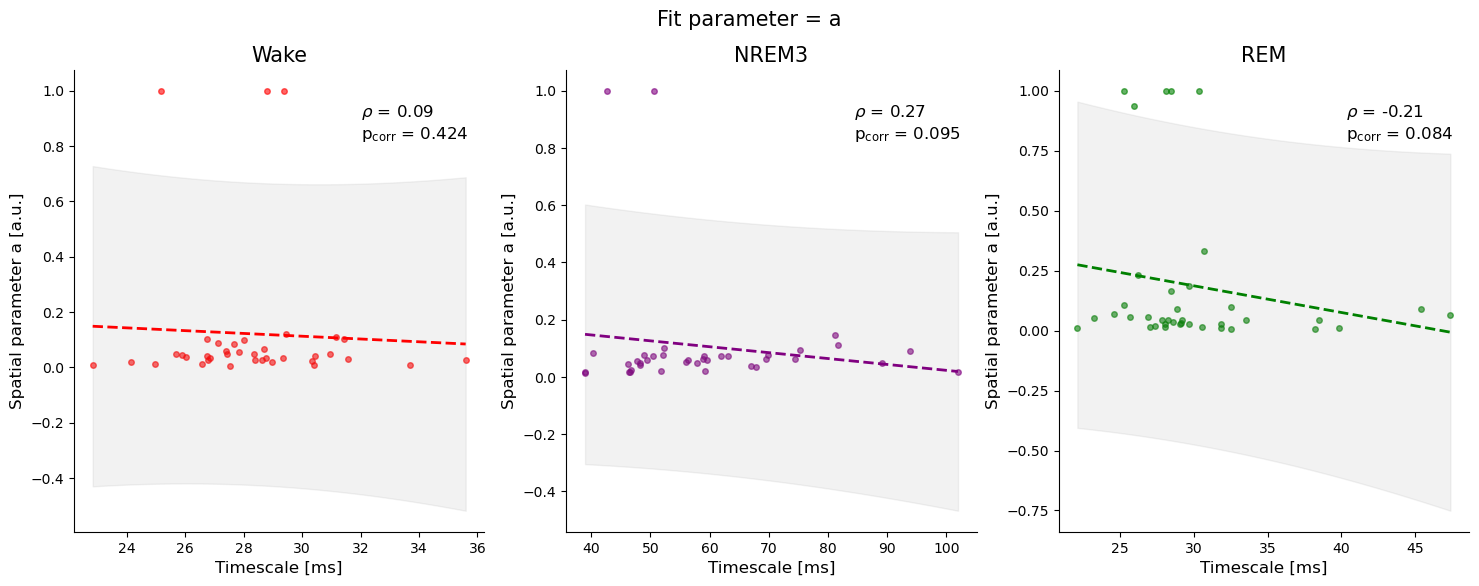

Stage: W, Param: b
Generating 1000 permutations...
Stage: N3, Param: b
Generating 1000 permutations...
Stage: R, Param: b
Generating 1000 permutations...


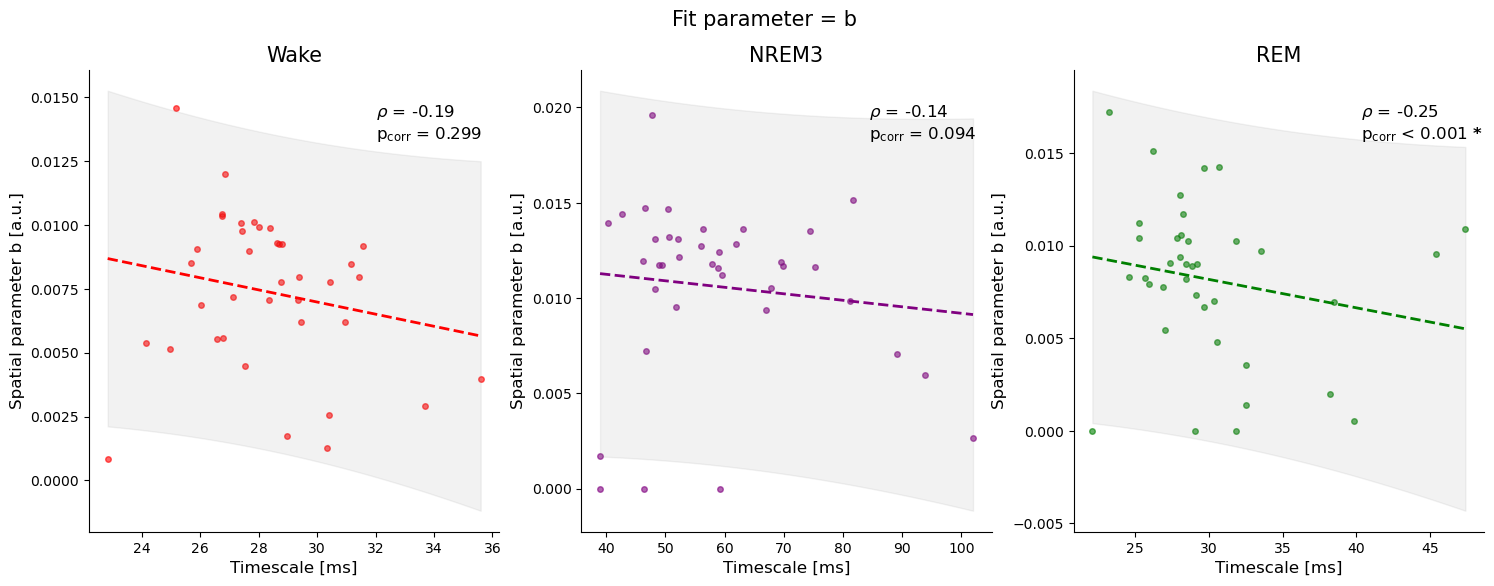

In [14]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Plot one figure per parameter
for param in ["k", "a", "b"]:

    # Define figure
    fig, axs = plt.subplots(1, 3, figsize=[18, 6])
    fig.suptitle(f"Fit parameter = {param}", fontsize=15)

    # One subplot per stage
    for i, stage in enumerate(["W", "N3", "R"]):
        print(f"Stage: {stage}, Param: {param}")

        # Get average tau per MNI region
        df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())

        # Get spatial parameter
        df_spa = df_sc_params_mni_stages_bins[stage][param].astype(float)
        df_spa = df_spa.loc[df_tau_stage_mni.index]

        # Get correlation values
        rho, p_corr = uti.get_pcorr_mnia(
            df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
        )

        # Plot
        axs[i] = plot_corr(
            axs[i],
            df_tau_stage_mni.to_numpy().squeeze(),
            df_spa.to_numpy().squeeze(),
            rho,
            p_corr,
            color=colors_stage[stage],
            title=title_dict[stage],
            xlabel="Timescale [ms]",
            ylabel=f"Spatial parameter {param} [a.u.]",
        )

    plt.show()

With AUC values:

Stage: W
Generating 1000 permutations...
Stage: N3
Generating 1000 permutations...
Stage: R
Generating 1000 permutations...


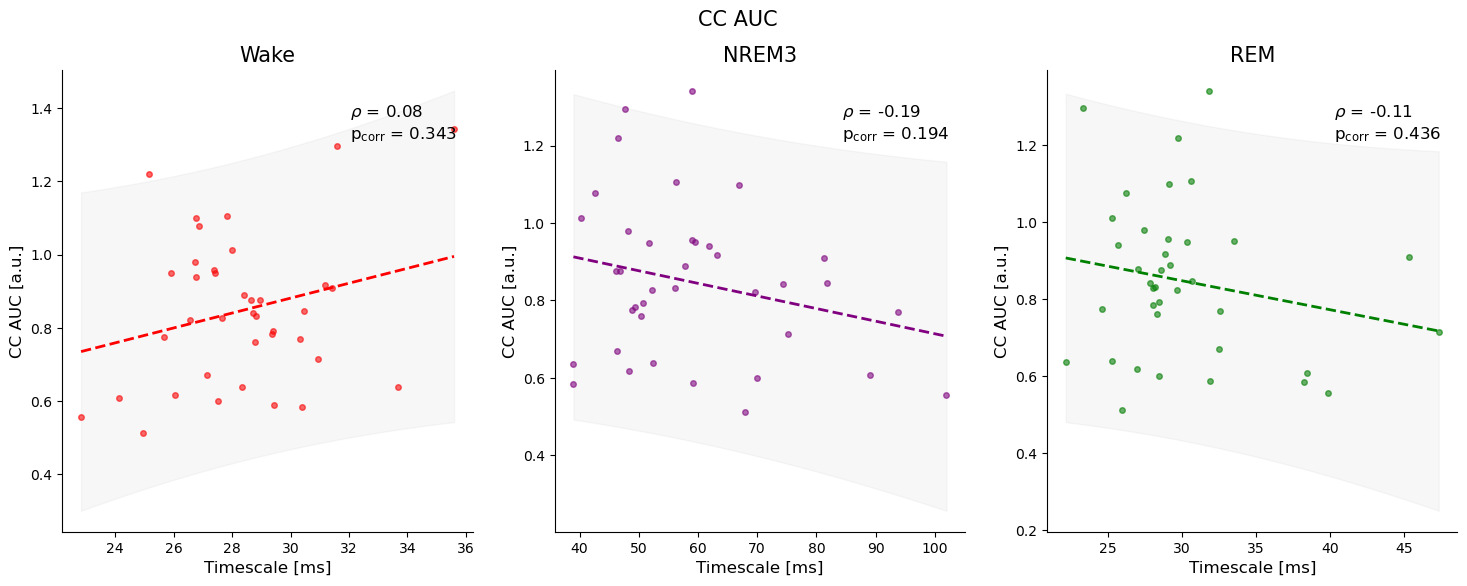

In [13]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Define figure
fig, axs = plt.subplots(1, 3, figsize=[18, 6])
fig.suptitle(f"CC AUC", fontsize=15)

# One subplot per stage
for i, stage in enumerate(["W", "N3", "R"]):
    print(f"Stage: {stage}")

    # Get average tau per MNI region
    df_tau_stage_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == stage].copy())
    
    def get_AUC(x):
        return x["a"] * x["k"] * (np.exp(-5/x["k"]) - np.exp(-80/x["k"])) + x["b"] * (80 - 5)

    df_spa = df_sc_params_mni_stages["W"].astype(float).apply(get_AUC, axis=1)
    # df_spa = pd.Series(auc_regions)
    df_spa = df_spa.loc[df_tau_stage_mni.index]

    # Get correlation values
    rho, p_corr = uti.get_pcorr_mnia(
        df_tau_stage_mni, df_spa, map_coords, method="vasa", corr_type="spearman"
    )

    # Plot
    axs[i] = plot_corr(
        axs[i],
        df_tau_stage_mni.to_numpy().squeeze(),
        df_spa.to_numpy().squeeze(),
        rho,
        p_corr,
        color=colors_stage[stage],
        title=title_dict[stage],
        xlabel="Timescale [ms]",
        ylabel=f"CC AUC [a.u.]",
    )

plt.show()